# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.231749 -0.231050  0.0  0.432344 -0.114830  0.116381  2  1   6.097601   
1  1.325174 -1.080612  0.0  0.929593 -0.726349  0.076760  3  1  10.194262   
2  0.204770 -0.415769  0.0  0.288978 -1.471662 -2.507972  1  3  -1.720668   
3 -1.401098  0.231546  0.0  0.851559 -0.936729  0.998402  1  3  10.684910   
4 -0.371536 -0.477363  0.0  0.464857 -2.156732  1.736986  2  0   1.652021   

            y  
0   64.992364  
1   86.274053  
2  -11.504137  
3  118.478051  
4   20.976498  
True causal estimate is 7.0157725790875745


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

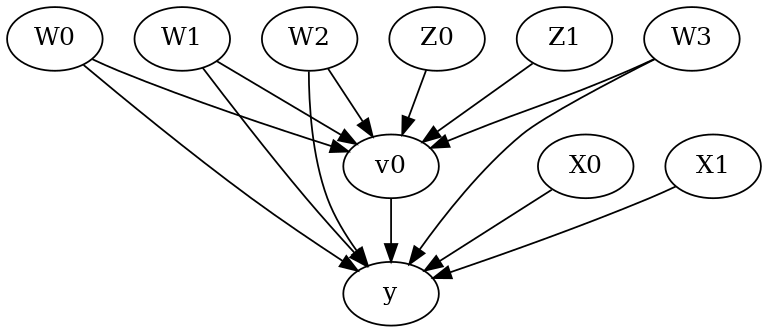

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W1,W3,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W3,W0,U) = P(y|v0,W2,W1,W3,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W1,W3,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W3,W0,U) = P(y|v0,W2,W1,W3,W0)

## Realized estimand
b: y~v0+W2+W1+W3+W0+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 7.015522453946055



## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W1,W3,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W3,W0,U) = P(y|v0,W2,W1,W3,W0)

## Realized estimand
b: y~v0+W2+W1+W3+W0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 8.832955504861756
Effect estimates: [[ 7.15809974]
 [ 8.23425738]
 [ 9.17911651]
 [ 2.31152959]
 [ 4.87413987]
 [13.88945749]
 [ 7.48876631]
 [13.49191116]
 [ 9.901151  ]
 [ 9.51314013]
 [11.21696872]
 [13.82425142]
 [ 8.84875949]
 [11.48307094]
 [ 7.62409547]
 [ 4.81389901]
 [ 8.69728372]
 [ 6.7418683 ]
 [ 9.97080827]
 [13.26662522]
 [ 6.62479954]
 [ 9.67326911]
 [ 6.15092419]
 [10.08013496]
 [ 7.16475572]
 [ 9.61003886]
 [12.05548322]
 [ 7.09182211]
 [14.18258511]
 [ 9.88070794]
 [10.04725786]
 [ 8.8006271 ]
 [16.77507642]
 [11.2338

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 7.0157725790875745


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W1,W3,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W3,W0,U) = P(y|v0,W2,W1,W3,W0)

## Realized estimand
b: y~v0+W2+W1+W3+W0 | X1,X0
Target units: 

## Estimate
Mean value: 6.980885342375103
Effect estimates: [[ 8.79227808]
 [ 7.15091214]
 [ 8.53751338]
 ...
 [ 9.89619029]
 [ 1.90096468]
 [10.43849856]]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W1,W3,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W3,W0,U) = P(y|v0,W2,W1,W3,W0)

## Realized estimand
b: y~v0+W2+W1+W3+W0 | X1,X0
Target units: ate

## Estimate
Mean value: 6.974156149627173
Effect estimates: [[ 8.77396024]
 [ 7.21351099]
 [ 8.53979988]
 ...
 [ 9.8780166 ]
 [ 1.9519431 ]
 [10.38780996]]



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[[12.43337338]
 [13.38053864]
 [12.49017405]
 [12.29965045]
 [14.18460261]
 [12.9641053 ]
 [11.14164049]
 [13.36192935]
 [12.97072348]
 [12.61823745]]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -0.687637  1.305058  0.0  0.246643 -1.776727  0.070906 -1.616338   
1    -0.034644 -0.270580  1.0  0.448639 -1.328533  0.030757 -0.840520   
2     0.148199 -0.497769  0.0  0.037648  0.384130  0.766809 -1.539789   
3    -2.305988  1.565223  1.0  0.590764  0.090576 -0.845310 -1.287641   
4     0.273624  1.157755  1.0  0.449999 -0.333091  0.438673 -0.171487   
...        ...       ...  ...       ...       ...       ...       ...   
9995  1.447140  1.524502  0.0  0.693979 -0.315689 -0.011742 -1.878542   
9996  1.127227  0.664885  1.0  0.106756 -0.797546 -1.196942  1.124172   
9997  0.062322  0.466745  1.0  0.227534  0.570694  0.647155  1.808832   
9998 -0.603649  0.156331  0.0  0.670349 -1.403030  0.534143  0.017783   
9999  1.012014  1.878713  0.0  0.305413 -0.693575  0.671762 -2.645115   

            W3  v0  y  
0    -1.165769   0  0  
1    -0.137571   1  1  
2     0.423423   0  1  
3    -0.081917   1  0  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.dr.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W1,W3,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W3,W0,U) = P(y|v0,W2,W1,W3,W0)

## Realized estimand
b: y~v0+W2+W1+W3+W0 | X1,X0
Target units: ate

## Estimate
Mean value: 0.4134623472831705
Effect estimates: [[0.36770075]
 [0.43748891]
 [0.45906686]
 ...
 [0.45709679]
 [0.3676722 ]
 [0.59384449]]

True causal estimate is 0.3477


### Instrumental Variable Method

In [16]:
import keras
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.iv.nnet.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-12-17 06:30:07.506804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-12-17 06:30:07.685861: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-17 06:30:07.685906: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-12-17 06:30:08.818794: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-17 06:30:08.819004: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-17 06:30:08.819022: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2022-12-17 06:30:10.073712: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-17 06:30:10.073786: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-17 06:30:10.073839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9585c334a631): /proc/driver/nvidia/version does not exist
2022-12-17 06:30:10.074620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 8:44 - loss: 26.8776

 19/313 [>.............................] - ETA: 0s - loss: 19.9994  

 40/313 [==>...........................] - ETA: 0s - loss: 11.8481

 62/313 [====>.........................] - ETA: 0s - loss: 8.8756 

 84/313 [=======>......................] - ETA: 0s - loss: 7.4230

104/313 [========>.....................] - ETA: 0s - loss: 6.5945

122/313 [==========>...................] - ETA: 0s - loss: 6.0802

145/313 [============>.................] - ETA: 0s - loss: 5.5873

166/313 [==============>...............] - ETA: 0s - loss: 5.2476

187/313 [================>.............] - ETA: 0s - loss: 4.9739

206/313 [==================>...........] - ETA: 0s - loss: 4.7631

226/313 [====================>.........] - ETA: 0s - loss: 4.5667

247/313 [======================>.......] - ETA: 0s - loss: 4.3960

267/313 [========================>.....] - ETA: 0s - loss: 4.2495

287/313 [==========================>...] - ETA: 0s - loss: 4.1203

308/313 [============================>.] - ETA: 0s - loss: 4.0011

313/313 [==============================] - 2s 3ms/step - loss: 3.9755


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 2.7680

 23/313 [=>............................] - ETA: 0s - loss: 2.3111

 43/313 [===>..........................] - ETA: 0s - loss: 2.3227

 64/313 [=====>........................] - ETA: 0s - loss: 2.3163

 84/313 [=======>......................] - ETA: 0s - loss: 2.2987

104/313 [========>.....................] - ETA: 0s - loss: 2.2766

125/313 [==========>...................] - ETA: 0s - loss: 2.2561

146/313 [============>.................] - ETA: 0s - loss: 2.2354

167/313 [===============>..............] - ETA: 0s - loss: 2.2152

188/313 [=================>............] - ETA: 0s - loss: 2.1921

208/313 [==================>...........] - ETA: 0s - loss: 2.1686

229/313 [====================>.........] - ETA: 0s - loss: 2.1512

248/313 [======================>.......] - ETA: 0s - loss: 2.1343

269/313 [========================>.....] - ETA: 0s - loss: 2.1152

289/313 [==========================>...] - ETA: 0s - loss: 2.0996

309/313 [============================>.] - ETA: 0s - loss: 2.0858

313/313 [==============================] - 1s 2ms/step - loss: 2.0829


Epoch 3/25


  1/313 [..............................] - ETA: 0s - loss: 1.9941

 21/313 [=>............................] - ETA: 0s - loss: 1.8137

 41/313 [==>...........................] - ETA: 0s - loss: 1.8002

 62/313 [====>.........................] - ETA: 0s - loss: 1.8279

 84/313 [=======>......................] - ETA: 0s - loss: 1.8315

106/313 [=========>....................] - ETA: 0s - loss: 1.8204

127/313 [===========>..................] - ETA: 0s - loss: 1.8189

146/313 [============>.................] - ETA: 0s - loss: 1.8161

167/313 [===============>..............] - ETA: 0s - loss: 1.8081

189/313 [=================>............] - ETA: 0s - loss: 1.8064

211/313 [===================>..........] - ETA: 0s - loss: 1.8087

232/313 [=====================>........] - ETA: 0s - loss: 1.8065

253/313 [=======================>......] - ETA: 0s - loss: 1.8031

275/313 [=========================>....] - ETA: 0s - loss: 1.7946

296/313 [===========================>..] - ETA: 0s - loss: 1.7911

313/313 [==============================] - 1s 2ms/step - loss: 1.7926


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 1.7085

 23/313 [=>............................] - ETA: 0s - loss: 1.8043

 45/313 [===>..........................] - ETA: 0s - loss: 1.8067

 66/313 [=====>........................] - ETA: 0s - loss: 1.7818

 87/313 [=======>......................] - ETA: 0s - loss: 1.7793

107/313 [=========>....................] - ETA: 0s - loss: 1.7625

128/313 [===========>..................] - ETA: 0s - loss: 1.7515

147/313 [=============>................] - ETA: 0s - loss: 1.7447

169/313 [===============>..............] - ETA: 0s - loss: 1.7442

191/313 [=================>............] - ETA: 0s - loss: 1.7433

212/313 [===================>..........] - ETA: 0s - loss: 1.7420

234/313 [=====================>........] - ETA: 0s - loss: 1.7382

255/313 [=======================>......] - ETA: 0s - loss: 1.7366

276/313 [=========================>....] - ETA: 0s - loss: 1.7397

292/313 [==========================>...] - ETA: 0s - loss: 1.7376

313/313 [==============================] - 1s 2ms/step - loss: 1.7362


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 1.9410

 23/313 [=>............................] - ETA: 0s - loss: 1.7050

 43/313 [===>..........................] - ETA: 0s - loss: 1.7136

 60/313 [====>.........................] - ETA: 0s - loss: 1.7095

 80/313 [======>.......................] - ETA: 0s - loss: 1.7076

102/313 [========>.....................] - ETA: 0s - loss: 1.7024

124/313 [==========>...................] - ETA: 0s - loss: 1.6914

145/313 [============>.................] - ETA: 0s - loss: 1.6942

166/313 [==============>...............] - ETA: 0s - loss: 1.6918

187/313 [================>.............] - ETA: 0s - loss: 1.6912

209/313 [===================>..........] - ETA: 0s - loss: 1.6999

231/313 [=====================>........] - ETA: 0s - loss: 1.6974

251/313 [=======================>......] - ETA: 0s - loss: 1.6918

267/313 [========================>.....] - ETA: 0s - loss: 1.6915

288/313 [==========================>...] - ETA: 0s - loss: 1.6963

310/313 [============================>.] - ETA: 0s - loss: 1.6961

313/313 [==============================] - 1s 2ms/step - loss: 1.6961


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 1.4855

 24/313 [=>............................] - ETA: 0s - loss: 1.6632

 46/313 [===>..........................] - ETA: 0s - loss: 1.6831

 68/313 [=====>........................] - ETA: 0s - loss: 1.6993

 89/313 [=======>......................] - ETA: 0s - loss: 1.6788

110/313 [=========>....................] - ETA: 0s - loss: 1.6795

131/313 [===========>..................] - ETA: 0s - loss: 1.6845

151/313 [=============>................] - ETA: 0s - loss: 1.6822

172/313 [===============>..............] - ETA: 0s - loss: 1.6801

194/313 [=================>............] - ETA: 0s - loss: 1.6695

214/313 [===================>..........] - ETA: 0s - loss: 1.6717

232/313 [=====================>........] - ETA: 0s - loss: 1.6719

251/313 [=======================>......] - ETA: 0s - loss: 1.6711

273/313 [=========================>....] - ETA: 0s - loss: 1.6694

295/313 [===========================>..] - ETA: 0s - loss: 1.6678

313/313 [==============================] - 1s 2ms/step - loss: 1.6652


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 1.5108

 22/313 [=>............................] - ETA: 0s - loss: 1.6846

 42/313 [===>..........................] - ETA: 0s - loss: 1.6815

 63/313 [=====>........................] - ETA: 0s - loss: 1.6759

 84/313 [=======>......................] - ETA: 0s - loss: 1.6940

102/313 [========>.....................] - ETA: 0s - loss: 1.6818

122/313 [==========>...................] - ETA: 0s - loss: 1.6778

144/313 [============>.................] - ETA: 0s - loss: 1.6721

166/313 [==============>...............] - ETA: 0s - loss: 1.6728

186/313 [================>.............] - ETA: 0s - loss: 1.6706

208/313 [==================>...........] - ETA: 0s - loss: 1.6609

230/313 [=====================>........] - ETA: 0s - loss: 1.6561

252/313 [=======================>......] - ETA: 0s - loss: 1.6625

272/313 [=========================>....] - ETA: 0s - loss: 1.6652

294/313 [===========================>..] - ETA: 0s - loss: 1.6611

313/313 [==============================] - 1s 2ms/step - loss: 1.6608


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 1.6103

 21/313 [=>............................] - ETA: 0s - loss: 1.6911

 42/313 [===>..........................] - ETA: 0s - loss: 1.6720

 63/313 [=====>........................] - ETA: 0s - loss: 1.6741

 84/313 [=======>......................] - ETA: 0s - loss: 1.6799

104/313 [========>.....................] - ETA: 0s - loss: 1.6755

126/313 [===========>..................] - ETA: 0s - loss: 1.6666

149/313 [=============>................] - ETA: 0s - loss: 1.6573

171/313 [===============>..............] - ETA: 0s - loss: 1.6538

194/313 [=================>............] - ETA: 0s - loss: 1.6535

214/313 [===================>..........] - ETA: 0s - loss: 1.6501

235/313 [=====================>........] - ETA: 0s - loss: 1.6459

256/313 [=======================>......] - ETA: 0s - loss: 1.6384

277/313 [=========================>....] - ETA: 0s - loss: 1.6376

297/313 [===========================>..] - ETA: 0s - loss: 1.6393

313/313 [==============================] - 1s 2ms/step - loss: 1.6380


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 1.6614

 23/313 [=>............................] - ETA: 0s - loss: 1.6262

 45/313 [===>..........................] - ETA: 0s - loss: 1.6270

 68/313 [=====>........................] - ETA: 0s - loss: 1.6374

 86/313 [=======>......................] - ETA: 0s - loss: 1.6245

107/313 [=========>....................] - ETA: 0s - loss: 1.6248

128/313 [===========>..................] - ETA: 0s - loss: 1.6264

145/313 [============>.................] - ETA: 0s - loss: 1.6215

166/313 [==============>...............] - ETA: 0s - loss: 1.6235

188/313 [=================>............] - ETA: 0s - loss: 1.6222

209/313 [===================>..........] - ETA: 0s - loss: 1.6235

229/313 [====================>.........] - ETA: 0s - loss: 1.6240

250/313 [======================>.......] - ETA: 0s - loss: 1.6242

272/313 [=========================>....] - ETA: 0s - loss: 1.6261

294/313 [===========================>..] - ETA: 0s - loss: 1.6226

313/313 [==============================] - 1s 2ms/step - loss: 1.6210


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 1.3791

 24/313 [=>............................] - ETA: 0s - loss: 1.6096

 46/313 [===>..........................] - ETA: 0s - loss: 1.6099

 67/313 [=====>........................] - ETA: 0s - loss: 1.6132

 89/313 [=======>......................] - ETA: 0s - loss: 1.6099

110/313 [=========>....................] - ETA: 0s - loss: 1.6172

131/313 [===========>..................] - ETA: 0s - loss: 1.6174

152/313 [=============>................] - ETA: 0s - loss: 1.6173

173/313 [===============>..............] - ETA: 0s - loss: 1.6167

193/313 [=================>............] - ETA: 0s - loss: 1.6168

214/313 [===================>..........] - ETA: 0s - loss: 1.6141

235/313 [=====================>........] - ETA: 0s - loss: 1.6152

257/313 [=======================>......] - ETA: 0s - loss: 1.6137

277/313 [=========================>....] - ETA: 0s - loss: 1.6087

297/313 [===========================>..] - ETA: 0s - loss: 1.6087

313/313 [==============================] - 1s 2ms/step - loss: 1.6088


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 1.6084

 22/313 [=>............................] - ETA: 0s - loss: 1.6379

 43/313 [===>..........................] - ETA: 0s - loss: 1.6309

 61/313 [====>.........................] - ETA: 0s - loss: 1.6271

 80/313 [======>.......................] - ETA: 0s - loss: 1.6161

101/313 [========>.....................] - ETA: 0s - loss: 1.6248

122/313 [==========>...................] - ETA: 0s - loss: 1.6201

144/313 [============>.................] - ETA: 0s - loss: 1.6195

165/313 [==============>...............] - ETA: 0s - loss: 1.6177

186/313 [================>.............] - ETA: 0s - loss: 1.6121

207/313 [==================>...........] - ETA: 0s - loss: 1.6127

228/313 [====================>.........] - ETA: 0s - loss: 1.6072

248/313 [======================>.......] - ETA: 0s - loss: 1.6063

269/313 [========================>.....] - ETA: 0s - loss: 1.6072

289/313 [==========================>...] - ETA: 0s - loss: 1.6077

311/313 [============================>.] - ETA: 0s - loss: 1.6043

313/313 [==============================] - 1s 2ms/step - loss: 1.6025


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 1.4789

 23/313 [=>............................] - ETA: 0s - loss: 1.6017

 44/313 [===>..........................] - ETA: 0s - loss: 1.5863

 65/313 [=====>........................] - ETA: 0s - loss: 1.5977

 85/313 [=======>......................] - ETA: 0s - loss: 1.5926

104/313 [========>.....................] - ETA: 0s - loss: 1.5994

123/313 [==========>...................] - ETA: 0s - loss: 1.5950

143/313 [============>.................] - ETA: 0s - loss: 1.5913

163/313 [==============>...............] - ETA: 0s - loss: 1.5930

183/313 [================>.............] - ETA: 0s - loss: 1.5928

202/313 [==================>...........] - ETA: 0s - loss: 1.5965

223/313 [====================>.........] - ETA: 0s - loss: 1.5938

242/313 [======================>.......] - ETA: 0s - loss: 1.5926

262/313 [========================>.....] - ETA: 0s - loss: 1.5921

280/313 [=========================>....] - ETA: 0s - loss: 1.5951

301/313 [===========================>..] - ETA: 0s - loss: 1.5948

313/313 [==============================] - 1s 3ms/step - loss: 1.5956


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 1.3263

 22/313 [=>............................] - ETA: 0s - loss: 1.5738

 43/313 [===>..........................] - ETA: 0s - loss: 1.5809

 64/313 [=====>........................] - ETA: 0s - loss: 1.5924

 85/313 [=======>......................] - ETA: 0s - loss: 1.5906

103/313 [========>.....................] - ETA: 0s - loss: 1.5932

122/313 [==========>...................] - ETA: 0s - loss: 1.5812

140/313 [============>.................] - ETA: 0s - loss: 1.5810

161/313 [==============>...............] - ETA: 0s - loss: 1.5853

181/313 [================>.............] - ETA: 0s - loss: 1.5881

202/313 [==================>...........] - ETA: 0s - loss: 1.5837

221/313 [====================>.........] - ETA: 0s - loss: 1.5810

242/313 [======================>.......] - ETA: 0s - loss: 1.5807

263/313 [========================>.....] - ETA: 0s - loss: 1.5788

282/313 [==========================>...] - ETA: 0s - loss: 1.5773

302/313 [===========================>..] - ETA: 0s - loss: 1.5757

313/313 [==============================] - 1s 3ms/step - loss: 1.5765


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 1.8644

 20/313 [>.............................] - ETA: 0s - loss: 1.5970

 40/313 [==>...........................] - ETA: 0s - loss: 1.5589

 60/313 [====>.........................] - ETA: 0s - loss: 1.5511

 80/313 [======>.......................] - ETA: 0s - loss: 1.5482

101/313 [========>.....................] - ETA: 0s - loss: 1.5585

122/313 [==========>...................] - ETA: 0s - loss: 1.5682

144/313 [============>.................] - ETA: 0s - loss: 1.5675

164/313 [==============>...............] - ETA: 0s - loss: 1.5671

185/313 [================>.............] - ETA: 0s - loss: 1.5675

206/313 [==================>...........] - ETA: 0s - loss: 1.5663

226/313 [====================>.........] - ETA: 0s - loss: 1.5651

247/313 [======================>.......] - ETA: 0s - loss: 1.5640

268/313 [========================>.....] - ETA: 0s - loss: 1.5635

288/313 [==========================>...] - ETA: 0s - loss: 1.5682

309/313 [============================>.] - ETA: 0s - loss: 1.5685

313/313 [==============================] - 1s 3ms/step - loss: 1.5689


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 1.6185

 22/313 [=>............................] - ETA: 0s - loss: 1.5242

 41/313 [==>...........................] - ETA: 0s - loss: 1.5442

 60/313 [====>.........................] - ETA: 0s - loss: 1.5707

 80/313 [======>.......................] - ETA: 0s - loss: 1.5628

 99/313 [========>.....................] - ETA: 0s - loss: 1.5596

119/313 [==========>...................] - ETA: 0s - loss: 1.5584

139/313 [============>.................] - ETA: 0s - loss: 1.5514

160/313 [==============>...............] - ETA: 0s - loss: 1.5542

181/313 [================>.............] - ETA: 0s - loss: 1.5588

199/313 [==================>...........] - ETA: 0s - loss: 1.5638

220/313 [====================>.........] - ETA: 0s - loss: 1.5640

240/313 [======================>.......] - ETA: 0s - loss: 1.5657

261/313 [========================>.....] - ETA: 0s - loss: 1.5638

280/313 [=========================>....] - ETA: 0s - loss: 1.5632

300/313 [===========================>..] - ETA: 0s - loss: 1.5614

313/313 [==============================] - 1s 3ms/step - loss: 1.5605


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 1.4279

 20/313 [>.............................] - ETA: 0s - loss: 1.5396

 39/313 [==>...........................] - ETA: 0s - loss: 1.5557

 59/313 [====>.........................] - ETA: 0s - loss: 1.5640

 79/313 [======>.......................] - ETA: 0s - loss: 1.5640

 99/313 [========>.....................] - ETA: 0s - loss: 1.5891

119/313 [==========>...................] - ETA: 0s - loss: 1.5794

140/313 [============>.................] - ETA: 0s - loss: 1.5777

161/313 [==============>...............] - ETA: 0s - loss: 1.5712

181/313 [================>.............] - ETA: 0s - loss: 1.5694

201/313 [==================>...........] - ETA: 0s - loss: 1.5675

222/313 [====================>.........] - ETA: 0s - loss: 1.5594

243/313 [======================>.......] - ETA: 0s - loss: 1.5549

265/313 [========================>.....] - ETA: 0s - loss: 1.5590

286/313 [==========================>...] - ETA: 0s - loss: 1.5588

307/313 [============================>.] - ETA: 0s - loss: 1.5565

313/313 [==============================] - 1s 3ms/step - loss: 1.5575


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 1.4247

 21/313 [=>............................] - ETA: 0s - loss: 1.5285

 42/313 [===>..........................] - ETA: 0s - loss: 1.5136

 60/313 [====>.........................] - ETA: 0s - loss: 1.5224

 82/313 [======>.......................] - ETA: 0s - loss: 1.5269

103/313 [========>.....................] - ETA: 0s - loss: 1.5364

124/313 [==========>...................] - ETA: 0s - loss: 1.5350

143/313 [============>.................] - ETA: 0s - loss: 1.5396

162/313 [==============>...............] - ETA: 0s - loss: 1.5409

182/313 [================>.............] - ETA: 0s - loss: 1.5411

202/313 [==================>...........] - ETA: 0s - loss: 1.5493

221/313 [====================>.........] - ETA: 0s - loss: 1.5480

241/313 [======================>.......] - ETA: 0s - loss: 1.5480

262/313 [========================>.....] - ETA: 0s - loss: 1.5528

282/313 [==========================>...] - ETA: 0s - loss: 1.5537

303/313 [============================>.] - ETA: 0s - loss: 1.5563

313/313 [==============================] - 1s 3ms/step - loss: 1.5561


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 1.4258

 22/313 [=>............................] - ETA: 0s - loss: 1.5812

 42/313 [===>..........................] - ETA: 0s - loss: 1.5645

 62/313 [====>.........................] - ETA: 0s - loss: 1.5588

 83/313 [======>.......................] - ETA: 0s - loss: 1.5671

104/313 [========>.....................] - ETA: 0s - loss: 1.5681

118/313 [==========>...................] - ETA: 0s - loss: 1.5604

139/313 [============>.................] - ETA: 0s - loss: 1.5561

160/313 [==============>...............] - ETA: 0s - loss: 1.5558

182/313 [================>.............] - ETA: 0s - loss: 1.5544

202/313 [==================>...........] - ETA: 0s - loss: 1.5533

222/313 [====================>.........] - ETA: 0s - loss: 1.5534

243/313 [======================>.......] - ETA: 0s - loss: 1.5528

265/313 [========================>.....] - ETA: 0s - loss: 1.5520

285/313 [==========================>...] - ETA: 0s - loss: 1.5518

306/313 [============================>.] - ETA: 0s - loss: 1.5528

313/313 [==============================] - 1s 3ms/step - loss: 1.5545


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 1.5576

 20/313 [>.............................] - ETA: 0s - loss: 1.5480

 39/313 [==>...........................] - ETA: 0s - loss: 1.5293

 59/313 [====>.........................] - ETA: 0s - loss: 1.5325

 79/313 [======>.......................] - ETA: 0s - loss: 1.5463

100/313 [========>.....................] - ETA: 0s - loss: 1.5520

121/313 [==========>...................] - ETA: 0s - loss: 1.5485

142/313 [============>.................] - ETA: 0s - loss: 1.5489

163/313 [==============>...............] - ETA: 0s - loss: 1.5504

184/313 [================>.............] - ETA: 0s - loss: 1.5544

206/313 [==================>...........] - ETA: 0s - loss: 1.5570

228/313 [====================>.........] - ETA: 0s - loss: 1.5556

249/313 [======================>.......] - ETA: 0s - loss: 1.5566

270/313 [========================>.....] - ETA: 0s - loss: 1.5551

289/313 [==========================>...] - ETA: 0s - loss: 1.5548

308/313 [============================>.] - ETA: 0s - loss: 1.5566

313/313 [==============================] - 1s 3ms/step - loss: 1.5558


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 1.4409

 22/313 [=>............................] - ETA: 0s - loss: 1.5512

 44/313 [===>..........................] - ETA: 0s - loss: 1.5573

 65/313 [=====>........................] - ETA: 0s - loss: 1.5440

 85/313 [=======>......................] - ETA: 0s - loss: 1.5439

106/313 [=========>....................] - ETA: 0s - loss: 1.5405

126/313 [===========>..................] - ETA: 0s - loss: 1.5352

147/313 [=============>................] - ETA: 0s - loss: 1.5428

170/313 [===============>..............] - ETA: 0s - loss: 1.5409

191/313 [=================>............] - ETA: 0s - loss: 1.5412

214/313 [===================>..........] - ETA: 0s - loss: 1.5424

236/313 [=====================>........] - ETA: 0s - loss: 1.5422

258/313 [=======================>......] - ETA: 0s - loss: 1.5417

280/313 [=========================>....] - ETA: 0s - loss: 1.5400

300/313 [===========================>..] - ETA: 0s - loss: 1.5431

313/313 [==============================] - 1s 2ms/step - loss: 1.5463


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 1.6457

 23/313 [=>............................] - ETA: 0s - loss: 1.5672

 45/313 [===>..........................] - ETA: 0s - loss: 1.5873

 66/313 [=====>........................] - ETA: 0s - loss: 1.5822

 87/313 [=======>......................] - ETA: 0s - loss: 1.5742

108/313 [=========>....................] - ETA: 0s - loss: 1.5703

129/313 [===========>..................] - ETA: 0s - loss: 1.5637

149/313 [=============>................] - ETA: 0s - loss: 1.5603

171/313 [===============>..............] - ETA: 0s - loss: 1.5590

192/313 [=================>............] - ETA: 0s - loss: 1.5536

213/313 [===================>..........] - ETA: 0s - loss: 1.5502

234/313 [=====================>........] - ETA: 0s - loss: 1.5475

255/313 [=======================>......] - ETA: 0s - loss: 1.5467

277/313 [=========================>....] - ETA: 0s - loss: 1.5430

298/313 [===========================>..] - ETA: 0s - loss: 1.5438

313/313 [==============================] - 1s 2ms/step - loss: 1.5439


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 1.6469

 23/313 [=>............................] - ETA: 0s - loss: 1.5615

 45/313 [===>..........................] - ETA: 0s - loss: 1.5444

 66/313 [=====>........................] - ETA: 0s - loss: 1.5371

 88/313 [=======>......................] - ETA: 0s - loss: 1.5434

109/313 [=========>....................] - ETA: 0s - loss: 1.5464

128/313 [===========>..................] - ETA: 0s - loss: 1.5517

149/313 [=============>................] - ETA: 0s - loss: 1.5427

169/313 [===============>..............] - ETA: 0s - loss: 1.5396

190/313 [=================>............] - ETA: 0s - loss: 1.5402

212/313 [===================>..........] - ETA: 0s - loss: 1.5409

232/313 [=====================>........] - ETA: 0s - loss: 1.5413

249/313 [======================>.......] - ETA: 0s - loss: 1.5413

270/313 [========================>.....] - ETA: 0s - loss: 1.5431

290/313 [==========================>...] - ETA: 0s - loss: 1.5396

311/313 [============================>.] - ETA: 0s - loss: 1.5412

313/313 [==============================] - 1s 2ms/step - loss: 1.5406


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 1.5059

 22/313 [=>............................] - ETA: 0s - loss: 1.5534

 41/313 [==>...........................] - ETA: 0s - loss: 1.5454

 60/313 [====>.........................] - ETA: 0s - loss: 1.5434

 81/313 [======>.......................] - ETA: 0s - loss: 1.5281

101/313 [========>.....................] - ETA: 0s - loss: 1.5321

121/313 [==========>...................] - ETA: 0s - loss: 1.5280

141/313 [============>.................] - ETA: 0s - loss: 1.5329

162/313 [==============>...............] - ETA: 0s - loss: 1.5284

183/313 [================>.............] - ETA: 0s - loss: 1.5326

203/313 [==================>...........] - ETA: 0s - loss: 1.5321

224/313 [====================>.........] - ETA: 0s - loss: 1.5360

244/313 [======================>.......] - ETA: 0s - loss: 1.5362

265/313 [========================>.....] - ETA: 0s - loss: 1.5376

285/313 [==========================>...] - ETA: 0s - loss: 1.5389

305/313 [============================>.] - ETA: 0s - loss: 1.5398

313/313 [==============================] - 1s 3ms/step - loss: 1.5419


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 1.3874

 17/313 [>.............................] - ETA: 0s - loss: 1.5208

 37/313 [==>...........................] - ETA: 0s - loss: 1.5283

 57/313 [====>.........................] - ETA: 0s - loss: 1.5364

 77/313 [======>.......................] - ETA: 0s - loss: 1.5336

 97/313 [========>.....................] - ETA: 0s - loss: 1.5280

113/313 [=========>....................] - ETA: 0s - loss: 1.5271

134/313 [===========>..................] - ETA: 0s - loss: 1.5333

155/313 [=============>................] - ETA: 0s - loss: 1.5419

176/313 [===============>..............] - ETA: 0s - loss: 1.5353

196/313 [=================>............] - ETA: 0s - loss: 1.5373

215/313 [===================>..........] - ETA: 0s - loss: 1.5374

234/313 [=====================>........] - ETA: 0s - loss: 1.5377

253/313 [=======================>......] - ETA: 0s - loss: 1.5416

274/313 [=========================>....] - ETA: 0s - loss: 1.5407

295/313 [===========================>..] - ETA: 0s - loss: 1.5397

313/313 [==============================] - 1s 3ms/step - loss: 1.5358


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 1.6442

 23/313 [=>............................] - ETA: 0s - loss: 1.5710

 45/313 [===>..........................] - ETA: 0s - loss: 1.5567

 66/313 [=====>........................] - ETA: 0s - loss: 1.5372

 87/313 [=======>......................] - ETA: 0s - loss: 1.5352

105/313 [=========>....................] - ETA: 0s - loss: 1.5337

127/313 [===========>..................] - ETA: 0s - loss: 1.5250

148/313 [=============>................] - ETA: 0s - loss: 1.5252

168/313 [===============>..............] - ETA: 0s - loss: 1.5238

189/313 [=================>............] - ETA: 0s - loss: 1.5274

210/313 [===================>..........] - ETA: 0s - loss: 1.5274

231/313 [=====================>........] - ETA: 0s - loss: 1.5266

252/313 [=======================>......] - ETA: 0s - loss: 1.5256

275/313 [=========================>....] - ETA: 0s - loss: 1.5258

296/313 [===========================>..] - ETA: 0s - loss: 1.5292

313/313 [==============================] - 1s 2ms/step - loss: 1.5307


Epoch 1/25


  1/313 [..............................] - ETA: 12:25 - loss: 4885.7461

 17/313 [>.............................] - ETA: 0s - loss: 7809.9668   

 35/313 [==>...........................] - ETA: 0s - loss: 7423.6641

 48/313 [===>..........................] - ETA: 0s - loss: 6867.8862

 66/313 [=====>........................] - ETA: 0s - loss: 5905.9648

 84/313 [=======>......................] - ETA: 0s - loss: 5232.7100

101/313 [========>.....................] - ETA: 0s - loss: 4891.8501

118/313 [==========>...................] - ETA: 0s - loss: 4603.6943

136/313 [============>.................] - ETA: 0s - loss: 4303.2197

154/313 [=============>................] - ETA: 0s - loss: 4040.5012

172/313 [===============>..............] - ETA: 0s - loss: 3851.5735

190/313 [=================>............] - ETA: 0s - loss: 3673.2068

208/313 [==================>...........] - ETA: 0s - loss: 3520.8845

226/313 [====================>.........] - ETA: 0s - loss: 3381.8376

243/313 [======================>.......] - ETA: 0s - loss: 3270.5259

261/313 [========================>.....] - ETA: 0s - loss: 3157.3252

279/313 [=========================>....] - ETA: 0s - loss: 3055.7297

297/313 [===========================>..] - ETA: 0s - loss: 2975.4175

313/313 [==============================] - 3s 3ms/step - loss: 2902.2139


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 1561.4851

 19/313 [>.............................] - ETA: 0s - loss: 1597.0367

 37/313 [==>...........................] - ETA: 0s - loss: 1670.0920

 52/313 [===>..........................] - ETA: 0s - loss: 1648.2802

 68/313 [=====>........................] - ETA: 0s - loss: 1634.8593

 85/313 [=======>......................] - ETA: 0s - loss: 1628.9447

103/313 [========>.....................] - ETA: 0s - loss: 1597.7052

120/313 [==========>...................] - ETA: 0s - loss: 1595.0509

136/313 [============>.................] - ETA: 0s - loss: 1584.9417

154/313 [=============>................] - ETA: 0s - loss: 1603.1731

171/313 [===============>..............] - ETA: 0s - loss: 1585.1041

187/313 [================>.............] - ETA: 0s - loss: 1579.4026

205/313 [==================>...........] - ETA: 0s - loss: 1601.2698

223/313 [====================>.........] - ETA: 0s - loss: 1590.6813

240/313 [======================>.......] - ETA: 0s - loss: 1615.5568

255/313 [=======================>......] - ETA: 0s - loss: 1632.9290

273/313 [=========================>....] - ETA: 0s - loss: 1632.2478

291/313 [==========================>...] - ETA: 0s - loss: 1629.7118

309/313 [============================>.] - ETA: 0s - loss: 1628.1464

313/313 [==============================] - 1s 3ms/step - loss: 1628.7295


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 1163.8641

 19/313 [>.............................] - ETA: 0s - loss: 1853.9568

 37/313 [==>...........................] - ETA: 0s - loss: 1712.6476

 54/313 [====>.........................] - ETA: 0s - loss: 1674.0667

 71/313 [=====>........................] - ETA: 0s - loss: 1605.1699

 89/313 [=======>......................] - ETA: 0s - loss: 1587.8857

106/313 [=========>....................] - ETA: 0s - loss: 1540.9572

123/313 [==========>...................] - ETA: 0s - loss: 1535.8694

141/313 [============>.................] - ETA: 0s - loss: 1536.0653

159/313 [==============>...............] - ETA: 0s - loss: 1528.7231

177/313 [===============>..............] - ETA: 0s - loss: 1532.5132

194/313 [=================>............] - ETA: 0s - loss: 1541.8900

211/313 [===================>..........] - ETA: 0s - loss: 1546.0703

226/313 [====================>.........] - ETA: 0s - loss: 1538.5688

243/313 [======================>.......] - ETA: 0s - loss: 1552.3008

260/313 [=======================>......] - ETA: 0s - loss: 1550.0319

277/313 [=========================>....] - ETA: 0s - loss: 1541.5737

294/313 [===========================>..] - ETA: 0s - loss: 1538.5568

310/313 [============================>.] - ETA: 0s - loss: 1535.0648

313/313 [==============================] - 1s 3ms/step - loss: 1535.8878


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 942.4665

 20/313 [>.............................] - ETA: 0s - loss: 1289.2527

 36/313 [==>...........................] - ETA: 0s - loss: 1351.1698

 49/313 [===>..........................] - ETA: 0s - loss: 1377.3551

 66/313 [=====>........................] - ETA: 0s - loss: 1375.5909

 84/313 [=======>......................] - ETA: 0s - loss: 1362.6604

102/313 [========>.....................] - ETA: 0s - loss: 1336.2843

119/313 [==========>...................] - ETA: 0s - loss: 1330.0956

136/313 [============>.................] - ETA: 0s - loss: 1341.5500

154/313 [=============>................] - ETA: 0s - loss: 1374.9928

171/313 [===============>..............] - ETA: 0s - loss: 1376.1111

187/313 [================>.............] - ETA: 0s - loss: 1375.4921

204/313 [==================>...........] - ETA: 0s - loss: 1385.2412

221/313 [====================>.........] - ETA: 0s - loss: 1379.0096

238/313 [=====================>........] - ETA: 0s - loss: 1383.9608

256/313 [=======================>......] - ETA: 0s - loss: 1396.0869

273/313 [=========================>....] - ETA: 0s - loss: 1404.7629

290/313 [==========================>...] - ETA: 0s - loss: 1403.8403

307/313 [============================>.] - ETA: 0s - loss: 1396.0918

313/313 [==============================] - 1s 3ms/step - loss: 1396.4702


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 1096.8593

 19/313 [>.............................] - ETA: 0s - loss: 1393.7631

 35/313 [==>...........................] - ETA: 0s - loss: 1388.2263

 52/313 [===>..........................] - ETA: 0s - loss: 1406.8158

 70/313 [=====>........................] - ETA: 0s - loss: 1400.2577

 88/313 [=======>......................] - ETA: 0s - loss: 1407.6150

106/313 [=========>....................] - ETA: 0s - loss: 1395.7267

124/313 [==========>...................] - ETA: 0s - loss: 1386.7834

142/313 [============>.................] - ETA: 0s - loss: 1400.7859

160/313 [==============>...............] - ETA: 0s - loss: 1399.1699

178/313 [================>.............] - ETA: 0s - loss: 1409.4773

194/313 [=================>............] - ETA: 0s - loss: 1398.6794

212/313 [===================>..........] - ETA: 0s - loss: 1383.2529

230/313 [=====================>........] - ETA: 0s - loss: 1389.0477

248/313 [======================>.......] - ETA: 0s - loss: 1397.8403

264/313 [========================>.....] - ETA: 0s - loss: 1397.9818

282/313 [==========================>...] - ETA: 0s - loss: 1392.6927

300/313 [===========================>..] - ETA: 0s - loss: 1389.4084

313/313 [==============================] - 1s 3ms/step - loss: 1385.1450


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 1848.5940

 17/313 [>.............................] - ETA: 0s - loss: 1207.3624

 32/313 [==>...........................] - ETA: 0s - loss: 1256.4979

 50/313 [===>..........................] - ETA: 0s - loss: 1371.1226

 68/313 [=====>........................] - ETA: 0s - loss: 1339.6064

 86/313 [=======>......................] - ETA: 0s - loss: 1340.3594

104/313 [========>.....................] - ETA: 0s - loss: 1370.7220

122/313 [==========>...................] - ETA: 0s - loss: 1361.6709

140/313 [============>.................] - ETA: 0s - loss: 1368.6039

158/313 [==============>...............] - ETA: 0s - loss: 1359.2322

172/313 [===============>..............] - ETA: 0s - loss: 1378.1400

190/313 [=================>............] - ETA: 0s - loss: 1402.0588

208/313 [==================>...........] - ETA: 0s - loss: 1392.7297

225/313 [====================>.........] - ETA: 0s - loss: 1390.1523

243/313 [======================>.......] - ETA: 0s - loss: 1399.1735

260/313 [=======================>......] - ETA: 0s - loss: 1414.9042

278/313 [=========================>....] - ETA: 0s - loss: 1411.3372

296/313 [===========================>..] - ETA: 0s - loss: 1409.4899

313/313 [==============================] - ETA: 0s - loss: 1417.5295

313/313 [==============================] - 1s 3ms/step - loss: 1417.5295


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 887.5483

 19/313 [>.............................] - ETA: 0s - loss: 1347.5420

 37/313 [==>...........................] - ETA: 0s - loss: 1286.7996

 55/313 [====>.........................] - ETA: 0s - loss: 1352.2625

 73/313 [=====>........................] - ETA: 0s - loss: 1330.3752

 91/313 [=======>......................] - ETA: 0s - loss: 1371.4762

109/313 [=========>....................] - ETA: 0s - loss: 1369.3026

126/313 [===========>..................] - ETA: 0s - loss: 1397.8438

141/313 [============>.................] - ETA: 0s - loss: 1409.0751

159/313 [==============>...............] - ETA: 0s - loss: 1405.4559

177/313 [===============>..............] - ETA: 0s - loss: 1403.8512

195/313 [=================>............] - ETA: 0s - loss: 1394.5719

213/313 [===================>..........] - ETA: 0s - loss: 1395.3153

229/313 [====================>.........] - ETA: 0s - loss: 1398.4198

246/313 [======================>.......] - ETA: 0s - loss: 1386.4839

262/313 [========================>.....] - ETA: 0s - loss: 1391.2156

278/313 [=========================>....] - ETA: 0s - loss: 1379.9663

296/313 [===========================>..] - ETA: 0s - loss: 1387.4282

313/313 [==============================] - 1s 3ms/step - loss: 1388.0676


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 1266.0537

 19/313 [>.............................] - ETA: 0s - loss: 1292.9484

 37/313 [==>...........................] - ETA: 0s - loss: 1415.3403

 54/313 [====>.........................] - ETA: 0s - loss: 1409.3188

 72/313 [=====>........................] - ETA: 0s - loss: 1400.8127

 90/313 [=======>......................] - ETA: 0s - loss: 1413.2523

107/313 [=========>....................] - ETA: 0s - loss: 1416.1779

123/313 [==========>...................] - ETA: 0s - loss: 1423.9624

141/313 [============>.................] - ETA: 0s - loss: 1428.4854

158/313 [==============>...............] - ETA: 0s - loss: 1414.9283

175/313 [===============>..............] - ETA: 0s - loss: 1400.2419

188/313 [=================>............] - ETA: 0s - loss: 1388.9105

204/313 [==================>...........] - ETA: 0s - loss: 1373.1780

222/313 [====================>.........] - ETA: 0s - loss: 1381.0267

240/313 [======================>.......] - ETA: 0s - loss: 1377.5676

257/313 [=======================>......] - ETA: 0s - loss: 1367.8712

275/313 [=========================>....] - ETA: 0s - loss: 1370.6249

293/313 [===========================>..] - ETA: 0s - loss: 1371.0479

311/313 [============================>.] - ETA: 0s - loss: 1365.0121

313/313 [==============================] - 1s 3ms/step - loss: 1366.1655


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 1476.4883

 19/313 [>.............................] - ETA: 0s - loss: 1251.5348

 34/313 [==>...........................] - ETA: 0s - loss: 1281.7043

 50/313 [===>..........................] - ETA: 0s - loss: 1298.1110

 67/313 [=====>........................] - ETA: 0s - loss: 1308.0221

 85/313 [=======>......................] - ETA: 0s - loss: 1299.8623

103/313 [========>.....................] - ETA: 0s - loss: 1312.3044

121/313 [==========>...................] - ETA: 0s - loss: 1343.9027

136/313 [============>.................] - ETA: 0s - loss: 1355.3629

151/313 [=============>................] - ETA: 0s - loss: 1368.0784

167/313 [===============>..............] - ETA: 0s - loss: 1368.2075

183/313 [================>.............] - ETA: 0s - loss: 1339.7689

199/313 [==================>...........] - ETA: 0s - loss: 1357.2158

215/313 [===================>..........] - ETA: 0s - loss: 1365.4246

230/313 [=====================>........] - ETA: 0s - loss: 1356.5540

247/313 [======================>.......] - ETA: 0s - loss: 1366.9294

265/313 [========================>.....] - ETA: 0s - loss: 1358.0162

283/313 [==========================>...] - ETA: 0s - loss: 1364.8756

300/313 [===========================>..] - ETA: 0s - loss: 1354.1232

313/313 [==============================] - 1s 3ms/step - loss: 1357.3729


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 1160.6304

 19/313 [>.............................] - ETA: 0s - loss: 1305.0450

 37/313 [==>...........................] - ETA: 0s - loss: 1377.4078

 55/313 [====>.........................] - ETA: 0s - loss: 1392.9547

 73/313 [=====>........................] - ETA: 0s - loss: 1360.1661

 88/313 [=======>......................] - ETA: 0s - loss: 1361.7130

106/313 [=========>....................] - ETA: 0s - loss: 1346.2517

123/313 [==========>...................] - ETA: 0s - loss: 1343.6514

140/313 [============>.................] - ETA: 0s - loss: 1333.0576

157/313 [==============>...............] - ETA: 0s - loss: 1340.9011

174/313 [===============>..............] - ETA: 0s - loss: 1337.4619

191/313 [=================>............] - ETA: 0s - loss: 1351.6328

209/313 [===================>..........] - ETA: 0s - loss: 1364.2897

226/313 [====================>.........] - ETA: 0s - loss: 1362.7709

243/313 [======================>.......] - ETA: 0s - loss: 1355.8696

261/313 [========================>.....] - ETA: 0s - loss: 1367.1602

279/313 [=========================>....] - ETA: 0s - loss: 1363.8451

295/313 [===========================>..] - ETA: 0s - loss: 1364.3669

312/313 [============================>.] - ETA: 0s - loss: 1366.7161

313/313 [==============================] - 1s 3ms/step - loss: 1367.6949


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 966.7554

 19/313 [>.............................] - ETA: 0s - loss: 1313.4069

 37/313 [==>...........................] - ETA: 0s - loss: 1335.6149

 54/313 [====>.........................] - ETA: 0s - loss: 1322.9695

 71/313 [=====>........................] - ETA: 0s - loss: 1366.0065

 85/313 [=======>......................] - ETA: 0s - loss: 1360.6240

103/313 [========>.....................] - ETA: 0s - loss: 1339.7074

119/313 [==========>...................] - ETA: 0s - loss: 1328.8752

137/313 [============>.................] - ETA: 0s - loss: 1337.4001

155/313 [=============>................] - ETA: 0s - loss: 1332.6512

173/313 [===============>..............] - ETA: 0s - loss: 1338.7692

191/313 [=================>............] - ETA: 0s - loss: 1345.5841

208/313 [==================>...........] - ETA: 0s - loss: 1320.0425

224/313 [====================>.........] - ETA: 0s - loss: 1312.8571

240/313 [======================>.......] - ETA: 0s - loss: 1312.4277

257/313 [=======================>......] - ETA: 0s - loss: 1309.5968

274/313 [=========================>....] - ETA: 0s - loss: 1303.8209

290/313 [==========================>...] - ETA: 0s - loss: 1309.4197

303/313 [============================>.] - ETA: 0s - loss: 1307.3326

313/313 [==============================] - 1s 3ms/step - loss: 1323.3411


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 2414.7690

 19/313 [>.............................] - ETA: 0s - loss: 1430.2371

 35/313 [==>...........................] - ETA: 0s - loss: 1310.4760

 50/313 [===>..........................] - ETA: 0s - loss: 1292.5032

 65/313 [=====>........................] - ETA: 0s - loss: 1300.0852

 81/313 [======>.......................] - ETA: 0s - loss: 1290.0575

 98/313 [========>.....................] - ETA: 0s - loss: 1274.4412

115/313 [==========>...................] - ETA: 0s - loss: 1314.6469

131/313 [===========>..................] - ETA: 0s - loss: 1306.7986

148/313 [=============>................] - ETA: 0s - loss: 1296.9216

166/313 [==============>...............] - ETA: 0s - loss: 1313.4503

184/313 [================>.............] - ETA: 0s - loss: 1337.2581

201/313 [==================>...........] - ETA: 0s - loss: 1330.3427

219/313 [===================>..........] - ETA: 0s - loss: 1318.6100

237/313 [=====================>........] - ETA: 0s - loss: 1322.8754

255/313 [=======================>......] - ETA: 0s - loss: 1330.8470

272/313 [=========================>....] - ETA: 0s - loss: 1334.2461

289/313 [==========================>...] - ETA: 0s - loss: 1335.9832

306/313 [============================>.] - ETA: 0s - loss: 1337.1448

313/313 [==============================] - 1s 3ms/step - loss: 1339.3254


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 1115.7999

 18/313 [>.............................] - ETA: 0s - loss: 1500.7837

 35/313 [==>...........................] - ETA: 0s - loss: 1393.6190

 51/313 [===>..........................] - ETA: 0s - loss: 1319.1117

 67/313 [=====>........................] - ETA: 0s - loss: 1269.9189

 84/313 [=======>......................] - ETA: 0s - loss: 1282.6405

100/313 [========>.....................] - ETA: 0s - loss: 1329.8575

117/313 [==========>...................] - ETA: 0s - loss: 1350.7356

133/313 [===========>..................] - ETA: 0s - loss: 1321.5228

151/313 [=============>................] - ETA: 0s - loss: 1322.6606

169/313 [===============>..............] - ETA: 0s - loss: 1325.6254

187/313 [================>.............] - ETA: 0s - loss: 1317.8175

205/313 [==================>...........] - ETA: 0s - loss: 1329.8694

222/313 [====================>.........] - ETA: 0s - loss: 1346.2584

239/313 [=====================>........] - ETA: 0s - loss: 1341.1766

256/313 [=======================>......] - ETA: 0s - loss: 1330.7676

273/313 [=========================>....] - ETA: 0s - loss: 1323.5957

290/313 [==========================>...] - ETA: 0s - loss: 1324.1420

307/313 [============================>.] - ETA: 0s - loss: 1323.5319

313/313 [==============================] - 1s 3ms/step - loss: 1322.4415


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 1498.6450

 17/313 [>.............................] - ETA: 0s - loss: 1178.6403

 34/313 [==>...........................] - ETA: 0s - loss: 1207.3130

 51/313 [===>..........................] - ETA: 0s - loss: 1240.8223

 68/313 [=====>........................] - ETA: 0s - loss: 1284.2721

 84/313 [=======>......................] - ETA: 0s - loss: 1286.5931

 99/313 [========>.....................] - ETA: 0s - loss: 1302.1787

116/313 [==========>...................] - ETA: 0s - loss: 1293.5547

133/313 [===========>..................] - ETA: 0s - loss: 1302.3530

150/313 [=============>................] - ETA: 0s - loss: 1314.6147

167/313 [===============>..............] - ETA: 0s - loss: 1310.3818

185/313 [================>.............] - ETA: 0s - loss: 1305.9354

203/313 [==================>...........] - ETA: 0s - loss: 1307.1154

221/313 [====================>.........] - ETA: 0s - loss: 1308.5194

239/313 [=====================>........] - ETA: 0s - loss: 1299.4509

256/313 [=======================>......] - ETA: 0s - loss: 1301.5424

273/313 [=========================>....] - ETA: 0s - loss: 1305.1443

289/313 [==========================>...] - ETA: 0s - loss: 1306.1962

306/313 [============================>.] - ETA: 0s - loss: 1312.1461

313/313 [==============================] - 1s 3ms/step - loss: 1307.4308


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 1094.8090

 19/313 [>.............................] - ETA: 0s - loss: 1084.9485

 36/313 [==>...........................] - ETA: 0s - loss: 1224.5585

 53/313 [====>.........................] - ETA: 0s - loss: 1237.9596

 70/313 [=====>........................] - ETA: 0s - loss: 1276.9849

 87/313 [=======>......................] - ETA: 0s - loss: 1315.7777

102/313 [========>.....................] - ETA: 0s - loss: 1316.6979

119/313 [==========>...................] - ETA: 0s - loss: 1310.7216

135/313 [===========>..................] - ETA: 0s - loss: 1321.7285

152/313 [=============>................] - ETA: 0s - loss: 1312.3831

169/313 [===============>..............] - ETA: 0s - loss: 1317.0439

185/313 [================>.............] - ETA: 0s - loss: 1310.2579

202/313 [==================>...........] - ETA: 0s - loss: 1318.4764

220/313 [====================>.........] - ETA: 0s - loss: 1318.5948

236/313 [=====================>........] - ETA: 0s - loss: 1320.6024

251/313 [=======================>......] - ETA: 0s - loss: 1330.2808

268/313 [========================>.....] - ETA: 0s - loss: 1336.0127

286/313 [==========================>...] - ETA: 0s - loss: 1331.3907

304/313 [============================>.] - ETA: 0s - loss: 1330.0104

313/313 [==============================] - 1s 3ms/step - loss: 1320.9609


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 1700.2124

 18/313 [>.............................] - ETA: 0s - loss: 1309.2837

 36/313 [==>...........................] - ETA: 0s - loss: 1328.7552

 53/313 [====>.........................] - ETA: 0s - loss: 1330.5280

 70/313 [=====>........................] - ETA: 0s - loss: 1300.5267

 87/313 [=======>......................] - ETA: 0s - loss: 1314.9919

103/313 [========>.....................] - ETA: 0s - loss: 1291.3452

116/313 [==========>...................] - ETA: 0s - loss: 1278.5200

132/313 [===========>..................] - ETA: 0s - loss: 1288.2395

148/313 [=============>................] - ETA: 0s - loss: 1310.2926

163/313 [==============>...............] - ETA: 0s - loss: 1328.1906

179/313 [================>.............] - ETA: 0s - loss: 1324.1472

195/313 [=================>............] - ETA: 0s - loss: 1323.0964

213/313 [===================>..........] - ETA: 0s - loss: 1324.8804

228/313 [====================>.........] - ETA: 0s - loss: 1312.5585

244/313 [======================>.......] - ETA: 0s - loss: 1315.8489

262/313 [========================>.....] - ETA: 0s - loss: 1324.8479

278/313 [=========================>....] - ETA: 0s - loss: 1331.8502

292/313 [==========================>...] - ETA: 0s - loss: 1333.0396

306/313 [============================>.] - ETA: 0s - loss: 1332.6007

313/313 [==============================] - 1s 3ms/step - loss: 1333.2623


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 1572.6013

 17/313 [>.............................] - ETA: 0s - loss: 1067.2418

 33/313 [==>...........................] - ETA: 0s - loss: 1234.0793

 51/313 [===>..........................] - ETA: 0s - loss: 1317.6039

 66/313 [=====>........................] - ETA: 0s - loss: 1347.9012

 79/313 [======>.......................] - ETA: 0s - loss: 1309.7908

 94/313 [========>.....................] - ETA: 0s - loss: 1312.9044

110/313 [=========>....................] - ETA: 0s - loss: 1296.7098

127/313 [===========>..................] - ETA: 0s - loss: 1293.8425

143/313 [============>.................] - ETA: 0s - loss: 1295.3718

159/313 [==============>...............] - ETA: 0s - loss: 1308.0162

176/313 [===============>..............] - ETA: 0s - loss: 1304.8165

192/313 [=================>............] - ETA: 0s - loss: 1310.3202

210/313 [===================>..........] - ETA: 0s - loss: 1312.2100

228/313 [====================>.........] - ETA: 0s - loss: 1321.0938

246/313 [======================>.......] - ETA: 0s - loss: 1330.9071

264/313 [========================>.....] - ETA: 0s - loss: 1328.3442

281/313 [=========================>....] - ETA: 0s - loss: 1329.7781

297/313 [===========================>..] - ETA: 0s - loss: 1334.3395

309/313 [============================>.] - ETA: 0s - loss: 1332.6760

313/313 [==============================] - 1s 3ms/step - loss: 1327.4956


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 1172.7172

 18/313 [>.............................] - ETA: 0s - loss: 1283.5829

 34/313 [==>...........................] - ETA: 0s - loss: 1366.8773

 51/313 [===>..........................] - ETA: 0s - loss: 1314.2074

 68/313 [=====>........................] - ETA: 0s - loss: 1342.6755

 85/313 [=======>......................] - ETA: 0s - loss: 1292.5363

102/313 [========>.....................] - ETA: 0s - loss: 1324.7440

119/313 [==========>...................] - ETA: 0s - loss: 1326.4150

136/313 [============>.................] - ETA: 0s - loss: 1339.2303

153/313 [=============>................] - ETA: 0s - loss: 1341.6310

169/313 [===============>..............] - ETA: 0s - loss: 1333.9199

187/313 [================>.............] - ETA: 0s - loss: 1328.6862

202/313 [==================>...........] - ETA: 0s - loss: 1341.0311

219/313 [===================>..........] - ETA: 0s - loss: 1325.9153

236/313 [=====================>........] - ETA: 0s - loss: 1316.0215

254/313 [=======================>......] - ETA: 0s - loss: 1312.9888

271/313 [========================>.....] - ETA: 0s - loss: 1314.8936

289/313 [==========================>...] - ETA: 0s - loss: 1327.1464

307/313 [============================>.] - ETA: 0s - loss: 1331.1400

313/313 [==============================] - 1s 3ms/step - loss: 1344.5562


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 1647.2104

 19/313 [>.............................] - ETA: 0s - loss: 1510.0839

 36/313 [==>...........................] - ETA: 0s - loss: 1461.5962

 54/313 [====>.........................] - ETA: 0s - loss: 1399.7458

 71/313 [=====>........................] - ETA: 0s - loss: 1399.0106

 89/313 [=======>......................] - ETA: 0s - loss: 1436.7338

107/313 [=========>....................] - ETA: 0s - loss: 1401.6062

125/313 [==========>...................] - ETA: 0s - loss: 1404.5115

143/313 [============>.................] - ETA: 0s - loss: 1370.9182

160/313 [==============>...............] - ETA: 0s - loss: 1356.7579

176/313 [===============>..............] - ETA: 0s - loss: 1345.2401

191/313 [=================>............] - ETA: 0s - loss: 1343.0518

208/313 [==================>...........] - ETA: 0s - loss: 1345.2673

226/313 [====================>.........] - ETA: 0s - loss: 1347.4562

244/313 [======================>.......] - ETA: 0s - loss: 1346.6216

261/313 [========================>.....] - ETA: 0s - loss: 1344.1127

279/313 [=========================>....] - ETA: 0s - loss: 1352.5968

296/313 [===========================>..] - ETA: 0s - loss: 1350.9792

313/313 [==============================] - 1s 3ms/step - loss: 1341.8846


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 1817.3525

 19/313 [>.............................] - ETA: 0s - loss: 1332.7173

 37/313 [==>...........................] - ETA: 0s - loss: 1354.8971

 55/313 [====>.........................] - ETA: 0s - loss: 1250.3594

 73/313 [=====>........................] - ETA: 0s - loss: 1276.6431

 90/313 [=======>......................] - ETA: 0s - loss: 1275.2542

105/313 [=========>....................] - ETA: 0s - loss: 1268.8761

121/313 [==========>...................] - ETA: 0s - loss: 1246.2108

137/313 [============>.................] - ETA: 0s - loss: 1260.0507

154/313 [=============>................] - ETA: 0s - loss: 1295.2809

171/313 [===============>..............] - ETA: 0s - loss: 1279.2627

190/313 [=================>............] - ETA: 0s - loss: 1271.8524

207/313 [==================>...........] - ETA: 0s - loss: 1286.7257

223/313 [====================>.........] - ETA: 0s - loss: 1299.3036

240/313 [======================>.......] - ETA: 0s - loss: 1299.5709

256/313 [=======================>......] - ETA: 0s - loss: 1296.0494

273/313 [=========================>....] - ETA: 0s - loss: 1295.9797

292/313 [==========================>...] - ETA: 0s - loss: 1300.5162

309/313 [============================>.] - ETA: 0s - loss: 1298.9554

313/313 [==============================] - 1s 3ms/step - loss: 1304.9576


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 421.3627

 19/313 [>.............................] - ETA: 0s - loss: 1263.5286

 37/313 [==>...........................] - ETA: 0s - loss: 1305.1241

 55/313 [====>.........................] - ETA: 0s - loss: 1256.7948

 73/313 [=====>........................] - ETA: 0s - loss: 1306.9370

 90/313 [=======>......................] - ETA: 0s - loss: 1330.0785

108/313 [=========>....................] - ETA: 0s - loss: 1317.2394

126/313 [===========>..................] - ETA: 0s - loss: 1322.9124

143/313 [============>.................] - ETA: 0s - loss: 1327.2382

161/313 [==============>...............] - ETA: 0s - loss: 1319.3699

179/313 [================>.............] - ETA: 0s - loss: 1314.7219

197/313 [=================>............] - ETA: 0s - loss: 1319.7766

214/313 [===================>..........] - ETA: 0s - loss: 1327.6360

231/313 [=====================>........] - ETA: 0s - loss: 1312.6079

246/313 [======================>.......] - ETA: 0s - loss: 1325.8951

261/313 [========================>.....] - ETA: 0s - loss: 1319.2445

278/313 [=========================>....] - ETA: 0s - loss: 1311.0962

295/313 [===========================>..] - ETA: 0s - loss: 1311.3770

312/313 [============================>.] - ETA: 0s - loss: 1316.7992

313/313 [==============================] - 1s 3ms/step - loss: 1317.7996


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 497.8649

 18/313 [>.............................] - ETA: 0s - loss: 1416.3624

 34/313 [==>...........................] - ETA: 0s - loss: 1357.7181

 51/313 [===>..........................] - ETA: 0s - loss: 1345.9806

 69/313 [=====>........................] - ETA: 0s - loss: 1351.7657

 87/313 [=======>......................] - ETA: 0s - loss: 1351.3612

104/313 [========>.....................] - ETA: 0s - loss: 1360.1758

122/313 [==========>...................] - ETA: 0s - loss: 1370.6176

140/313 [============>.................] - ETA: 0s - loss: 1363.2590

158/313 [==============>...............] - ETA: 0s - loss: 1356.8275

176/313 [===============>..............] - ETA: 0s - loss: 1367.4852

193/313 [=================>............] - ETA: 0s - loss: 1369.4696

211/313 [===================>..........] - ETA: 0s - loss: 1371.3839

228/313 [====================>.........] - ETA: 0s - loss: 1363.3032

246/313 [======================>.......] - ETA: 0s - loss: 1342.7452

264/313 [========================>.....] - ETA: 0s - loss: 1335.3215

282/313 [==========================>...] - ETA: 0s - loss: 1335.9430

299/313 [===========================>..] - ETA: 0s - loss: 1332.7323

313/313 [==============================] - 1s 3ms/step - loss: 1328.1832


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2078.6121

 18/313 [>.............................] - ETA: 0s - loss: 1448.7834

 35/313 [==>...........................] - ETA: 0s - loss: 1426.8823

 53/313 [====>.........................] - ETA: 0s - loss: 1369.5670

 71/313 [=====>........................] - ETA: 0s - loss: 1409.5151

 89/313 [=======>......................] - ETA: 0s - loss: 1382.8912

107/313 [=========>....................] - ETA: 0s - loss: 1383.4933

125/313 [==========>...................] - ETA: 0s - loss: 1346.5175

143/313 [============>.................] - ETA: 0s - loss: 1360.4376

161/313 [==============>...............] - ETA: 0s - loss: 1338.7227

179/313 [================>.............] - ETA: 0s - loss: 1353.5490

194/313 [=================>............] - ETA: 0s - loss: 1346.8198

212/313 [===================>..........] - ETA: 0s - loss: 1350.0825

230/313 [=====================>........] - ETA: 0s - loss: 1334.0959

246/313 [======================>.......] - ETA: 0s - loss: 1350.3564

263/313 [========================>.....] - ETA: 0s - loss: 1344.6804

280/313 [=========================>....] - ETA: 0s - loss: 1348.3195

297/313 [===========================>..] - ETA: 0s - loss: 1336.1831

313/313 [==============================] - 1s 3ms/step - loss: 1340.4954


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 841.3374

 18/313 [>.............................] - ETA: 0s - loss: 1390.6685

 36/313 [==>...........................] - ETA: 0s - loss: 1341.8691

 54/313 [====>.........................] - ETA: 0s - loss: 1281.5602

 72/313 [=====>........................] - ETA: 0s - loss: 1272.6628

 88/313 [=======>......................] - ETA: 0s - loss: 1273.9006

106/313 [=========>....................] - ETA: 0s - loss: 1291.6433

124/313 [==========>...................] - ETA: 0s - loss: 1299.5181

142/313 [============>.................] - ETA: 0s - loss: 1319.6798

159/313 [==============>...............] - ETA: 0s - loss: 1303.4545

176/313 [===============>..............] - ETA: 0s - loss: 1294.5077

193/313 [=================>............] - ETA: 0s - loss: 1290.5986

211/313 [===================>..........] - ETA: 0s - loss: 1284.2639

229/313 [====================>.........] - ETA: 0s - loss: 1292.3523

247/313 [======================>.......] - ETA: 0s - loss: 1295.5803

265/313 [========================>.....] - ETA: 0s - loss: 1313.1589

282/313 [==========================>...] - ETA: 0s - loss: 1319.3488

300/313 [===========================>..] - ETA: 0s - loss: 1313.8021

313/313 [==============================] - 1s 3ms/step - loss: 1303.2614


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 1531.9819

 17/313 [>.............................] - ETA: 0s - loss: 1416.0294

 34/313 [==>...........................] - ETA: 0s - loss: 1396.7177

 48/313 [===>..........................] - ETA: 0s - loss: 1339.0245

 66/313 [=====>........................] - ETA: 0s - loss: 1358.3905

 84/313 [=======>......................] - ETA: 0s - loss: 1353.9410

102/313 [========>.....................] - ETA: 0s - loss: 1311.5197

120/313 [==========>...................] - ETA: 0s - loss: 1298.2833

138/313 [============>.................] - ETA: 0s - loss: 1325.3220

156/313 [=============>................] - ETA: 0s - loss: 1327.1688

174/313 [===============>..............] - ETA: 0s - loss: 1314.0448

192/313 [=================>............] - ETA: 0s - loss: 1318.6003

209/313 [===================>..........] - ETA: 0s - loss: 1317.4619

227/313 [====================>.........] - ETA: 0s - loss: 1319.7373

245/313 [======================>.......] - ETA: 0s - loss: 1311.6848

262/313 [========================>.....] - ETA: 0s - loss: 1302.6034

280/313 [=========================>....] - ETA: 0s - loss: 1321.9269

295/313 [===========================>..] - ETA: 0s - loss: 1322.3223

312/313 [============================>.] - ETA: 0s - loss: 1310.2721

313/313 [==============================] - 1s 3ms/step - loss: 1307.8616


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/229 [..............................] - ETA: 27s

 39/229 [====>.........................] - ETA: 0s 

 74/229 [========>.....................] - ETA: 0s

110/229 [=============>................] - ETA: 0s

148/229 [==================>...........] - ETA: 0s

185/229 [=======================>......] - ETA: 0s

221/229 [===========================>..] - ETA: 0s

229/229 [==============================] - 0s 1ms/step


  1/229 [..............................] - ETA: 5s

 38/229 [===>..........................] - ETA: 0s

 74/229 [========>.....................] - ETA: 0s

111/229 [=============>................] - ETA: 0s

147/229 [==================>...........] - ETA: 0s

183/229 [======================>.......] - ETA: 0s

219/229 [===========================>..] - ETA: 0s

229/229 [==============================] - 0s 1ms/step


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W2+W1+W3+W0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 2.8460025787353516
Effect estimates: [[3.049467 ]
 [3.1097584]
 [3.0448284]
 ...
 [3.82621  ]
 [1.0547352]
 [3.33012  ]]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -0.236292  1.694994  1.456045  0.026202 -1.212069  0.0  0.819180   
1    -0.362663  0.985746 -0.571583 -1.121384  1.039971  1.0  0.025306   
2     0.039441  0.965660  0.023658 -1.211357  2.487577  1.0  0.427634   
3    -2.140554  0.246800 -0.278683 -0.695483 -1.103899  0.0  0.949499   
4    -1.707221  1.513678 -0.061576  0.645485  0.156491  1.0  0.542356   
...        ...       ...       ...       ...       ...  ...       ...   
9995  1.956310  1.537336 -0.607708  0.925223  0.178134  1.0  0.371007   
9996  1.039545  0.836462 -0.021626 -1.568059 -0.367342  0.0  0.906037   
9997  1.585471 -0.501655 -0.271456  1.917785 -0.727508  0.0  0.172921   
9998  0.582521 -0.931256 -0.937264  0.223016  0.524265  0.0  0.903850   
9999 -1.564535  0.050755 -1.426214  1.169977 -0.480995  0.0  0.697222   

            W0        W1        W2        W3        W4  v0          y  
0    -1.374181 -3.034458  1.904003  0.943735 -1.556

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W1,W4,W3,W0])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W4,W3,W0,U) = P(y|v0,W2,W1,W4,W3,W0)

## Realized estimand
b: y~v0+X1+X0+X2+X3+X4+W2+W1+W4+W3+W0
Target units: ate

## Estimate
Mean value: 15.233151716128734
Effect estimates: [[16.20426816]
 [18.98894905]
 [22.83290267]
 ...
 [14.4591696 ]
 [13.48136352]
 [ 2.92450379]]

True causal estimate is 12.431476548771375


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W1,W4,W3,W0])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W4,W3,W0,U) = P(y|v0,W2,W1,W4,W3,W0)

## Realized estimand
b: y~v0+X1+X0+X2+X3+X4+W2+W1+W4+W3+W0
Target units: Data subset provided as a data frame

## Estimate
Mean value: 13.821445912796628
Effect estimates: [[23.81034197]
 [14.43185067]
 [14.4591696 ]
 [13.48136352]
 [ 2.92450379]]

True causal estimate is 12.431476548771375


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:12.784497519196872
New effect:12.778113773077708
p value:0.8799999999999999



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:12.784497519196872
New effect:12.760138507988101



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:12.784497519196872
New effect:-0.028281958703654558
p value:0.2852673239151562



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:12.784497519196872
New effect:12.770157083399821
p value:0.3769368810357151



More refutation methods to come, especially specific to the CATE estimators.